In [1]:
using LinearAlgebra,Polynomials,Printf,Random,ForwardDiff,PyPlot,PyCall,OffsetArrays,FFTW

In [2]:
np=pyimport("numpy")

PyObject <module 'numpy' from 'C:\\Users\\bryan\\.julia\\Conda_env\\lib\\site-packages\\numpy\\__init__.py'>

## helper functions

In [3]:
function opt_fft2(X)
    #center shifted fourier transform
    X_frq = fftshift(fft(ifftshift(X)))
    return X_frq
end

function opt_ifft2(X_frq)
    #center shifted inverse fourier transform
    X = fftshift(ifft(ifftshift(X_frq)))
    return X
end

function make_prop_kernel( sz, z; dl=2,lmbd=0.5, noShift = true)
    nx = sz[1]
    ny = sz[2]
    k=2*pi/lmbd # wavenumber
    dkx=2*pi/((nx-1)*dl)
    dky=2*pi/((ny-1)*dl)
    kx=(LinRange(0,nx-1,nx).-nx/2)*dkx
    ky=(LinRange(0,ny-1,ny).-ny/2)*dky

    inflate(f, kx, ky) = [f(x,y) for x in kx, y in ky]
    f(kx,ky)=exp(1im*sqrt(k^2-kx^2-ky^2)*z)

    prop_kernel=inflate(f,kx,ky)

    if noShift == true
        prop_kernel = ifftshift(prop_kernel)
    end
    return prop_kernel
end

function light_prop2(e_in, prop_kernel;noShift = true)
    if ndims(e_in) == 3
        prop_kernel = reshape(prop_kernel,(1,size(prop_kernel)...))
    end
    if noShift == true
        ek_in  = fft(ifftshift(e_in))
        ek_out = ek_in.*prop_kernel
        e_out  = fftshift(ifft(ek_out))
    else
        ek_in  = opt_fft2(e_in)
        ek_out = ek_in.*prop_kernel
        e_out  = opt_ifft2(ek_out)
    end
    return e_out
end

function phase_mod(e_in, theta; samp_ratio=1)
    #=
    e_in is the input field
    theta is the phase mask
    samp_ratio is the pixel size ratio between the phase mask and the e field 
    =#
    if ndims(e_in) == 2
        if samp_ratio == 1
            e_out = e_in.*exp.(1im*theta)
        else
            e_out = e_in.*kron(exp.(1im*theta),ones((samp_ratio,samp_ratio)))
        end
    elseif ndims(e_in) == 3
        if samp_ratio == 1
            M = exp.(1im*theta)
            e_out = e_in.*reshape(M,(1,size(M)...))
        else
            M = kron(exp.(1im*theta),ones((samp_ratio,samp_ratio)))
            e_out = e_in.*reshape(M,(1,size(M)...))
        end
    end
    return e_out
end

phase_mod (generic function with 1 method)

In [4]:
function light_prop(e_in, z; dl=2, lmbd=0.5)
    #=
    light propagation at distance z
    e_in: input field
    z: propagation distance
    dl: pixel size in um
    lmbd: wavelength in um
    =#
    if ndims(e_in) == 2
        nx, ny = size(e_in)
    elseif ndims(e_in) == 3
        nf, nx, ny = size(e_in)
    end
            
    k=2*pi/lmbd # wavenumber
    dkx=2*pi/((nx-1)*dl)
    dky=2*pi/((ny-1)*dl)
    kx=(LinRange(0,nx-1,nx).-nx/2)*dkx
    ky=(LinRange(0,ny-1,ny).-ny/2)*dky
    
    inflate(f, kx, ky) = [f(x,y) for x in kx, y in ky]
    f(kx,ky)=exp(1im*sqrt(k^2-kx^2-ky^2)*z)
    
    prop_kernel=inflate(f,kx,ky)
    #prop_kernel=np.exp(1j*(k-(kx_c**2+ky_c**2)/2/k)*z)
    if ndims(e_in) == 2
        ek_in = opt_fft2(e_in)
        ek_out = ek_in.*prop_kernel
        e_out = opt_ifft2(ek_out)
    elseif ndims(e_in) == 3
        e_out = zeros(ComplexF64,size(e_in))
        for ii = 1:nf
            ek_in = opt_fft2(e_in[ii,:,:])
            ek_out = ek_in.*prop_kernel
            e_out[ii,:,:] = opt_ifft2(ek_out)
        end
    end
    return e_out
end

light_prop (generic function with 1 method)

## Design of a 5-plane Optimization 

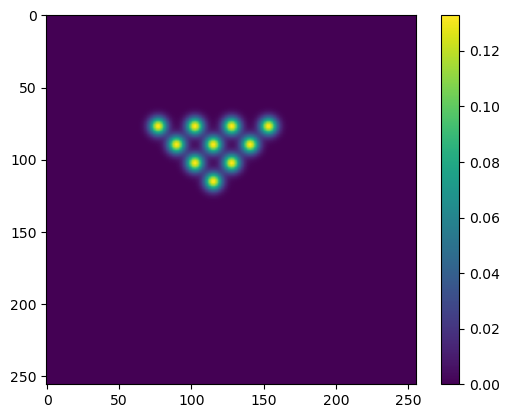

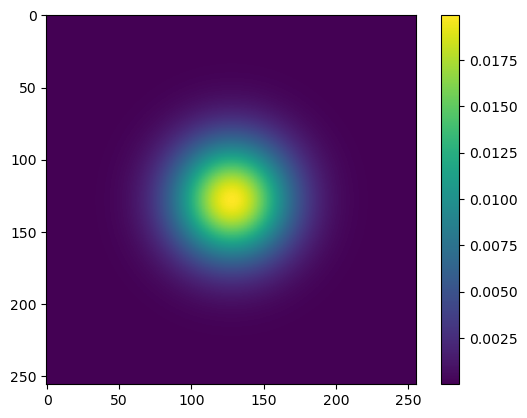

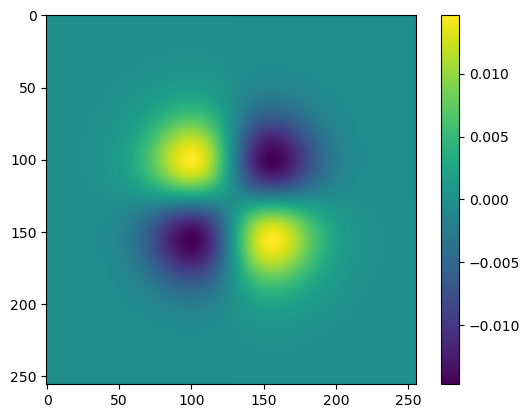

PyObject <matplotlib.colorbar.Colorbar object at 0x000000005C6162B0>

In [5]:
# wavelength
lmbd = 0.5 # in um
# coordinates
nx = 256
ny = 256
# pixel size
dl = 5 # unit um
#number of plates
npl = 5

x=(LinRange(0,nx-1,nx).-nx/2)*dl
y=(LinRange(0,ny-1,ny).-ny/2)*dl

#no idea what this is doing, is s_input the coordinate to create Gaussian spots?
s_input = Matrix(undef,sum(1:npl-1),2)
p = 90 # pitch
k=0
for  ii =1:npl-1
    ys = -ii*p*sqrt(2)/2
    for jj =0:ii-1
        k+=1
        xs = ys + jj*p*sqrt(2)
        s_input[k,:]=[xs,ys]
    end
end

nmod = size(s_input,1)
e_in = zeros(nmod, ny, nx)#why ny nx?
w_in = 30 # beam width
inflate(f, x, y, i) = [f(xx,yy,i) for xx in x, yy in y]
#Gaussian
f(x,y,i)=exp(-((x-s_input[i,1])^2+(y-s_input[i,2])^2)/w_in^2)
for ii = 1:nmod
    e = inflate(f,x,y,ii)
    I = sum(abs2,e)
    e_in[ii,:,:] = e'/sqrt(I) #normalize, x,y very confusing!!!
end

fig, ax = plt.subplots()
image=ax.imshow(dropdims(sum(e_in, dims=1),dims=1))
cbar=plt.colorbar(image)  

# output
e_out = zeros(nmod, ny, nx) #why ny nx?
w_out = 200
inflate(f, x, y) = [f(xx,yy) for xx in x, yy in y]
f(x,y)=exp(-(x^2+y^2)/w_out^2)
M = inflate(f,x,y)

for  ii = 1:npl-1
    for jj = 1:ii
        c = zeros(jj,ii-jj+1)
        c[jj,ii-jj+1]=1
        #only get the last term?
        e = np.polynomial.hermite.hermgrid2d(sqrt(2)*x/w_out, sqrt(2)*y/w_out, c).*M
        I = sum(abs2,e)
        kk = fld(ii*(ii-1),2)+jj# list index (it's actually just 1:10)
        e_out[kk,:,:] = e/sqrt(I)
    end
end

fig, ax = subplots()
image=ax.imshow(e_out[1,:,:])
cbar=colorbar(image)
fig, ax = subplots()
image=ax.imshow(e_out[5,:,:])
cbar=colorbar(image)

In [6]:
## 5 plates in between
npl = 5
#z, distance between 5 plates and input/output, 6 intervals among 7 things
d = [2e4,2.5e4,2.5e4,2.5e4,2.5e4,2e4]
theta = zeros(npl,nx,ny)
#
e_fwd = zeros(ComplexF64,npl+2,nmod,nx,ny) 
e_bwd = zeros(ComplexF64,npl+2,nmod,nx,ny) 
#each has 7 dims and 1 is reserved for the given input/output
e_fwd[1,:,:,:] = e_in
e_bwd[end,:,:,:] = e_out

# Stephen
noShift = true
kernelsForward   = zeros(ComplexF64,(npl+1,nx,ny))
kernelsBackward  = zeros(ComplexF64,(npl+1,nx,ny))
for jj = 1:npl+1
  kernelsForward[jj,:,:] = make_prop_kernel( (nx,ny), d[jj],dl=dl,lmbd=lmbd, noShift = noShift)
  kernelsBackward[jj,:,:] = make_prop_kernel( (nx,ny), -d[jj],dl=dl,lmbd=lmbd, noShift = noShift)
end
forwardPropagate(e_in, jj)  = light_prop2(e_in, kernelsForward[jj,:,:], noShift = noShift)
backwardPropagate(e_in, jj) = light_prop2(e_in, kernelsBackward[jj,:,:], noShift = noShift)

e_fwd_m = e_in
# initial backpropagate
e_bwd_m = e_out # modulated field

for jj = 1:npl #start with the last and go backward
    #e_bwd[-jj-2,:,:,:] = light_prop(e_bwd_m, -d[-jj-1], dl, lmbd)#backpropagates        
    e_bwd[end-jj,:,:,:] = backwardPropagate( e_bwd_m, npl+2-jj )
    e_bwd_m = phase_mod(e_bwd[end-jj,:,:,:], -theta[end-jj+1,:,:], samp_ratio=1)
end

nitr = 100 # number of iteration
# nitr = 2  # Stephen
#nitr = 300  # Stephen

function mainLoop()
    for ii = 1:nitr
        # forward update   
        e_fwd_m = e_in # initial modulated field
        # Compute forward propagation model
        for jj = 1:npl  # loop over plate
            # e_fwd[jj+1,:,:,:] = light_prop(e_fwd_m, d[jj], dl, lmbd)
            e_fwd[jj+1,:,:,:] = forwardPropagate(e_fwd_m, jj)
            e_sum = sum(e_fwd[jj+1,:,:,:].*conj.(e_bwd[jj+1,:,:,:]),dims=1)
            theta[jj,:,:] = -angle.(e_sum) # updates, where did this come from???
            e_fwd_m = phase_mod(e_fwd[jj+1,:,:,:], theta[jj,:,:], samp_ratio=1)
        end
        #e_fwd[npl+1,:,:,:] = light_prop(e_fwd_m, d[npl], dl, lmbd)
        #last part of forward only propagates but do not have phase change
        e_fwd[npl+2,:,:,:] = forwardPropagate(e_fwd_m, npl)

        # Our "loss" function (actually, want this to be 1, not zero)
        couple_eff = sum(abs.(e_fwd[npl+1,:,:,:].*conj.(e_out)))/nmod
        @printf "%d forward iteration, couple efficiency %f \n" ii couple_eff

        # Below here is specialized for the alternating minimization code

        # backward update
        e_bwd_m = e_out # initial modulated field
        for jj = 1:npl
            #e_bwd[-jj-2,:,:,:] = light_prop(e_bwd_m, -d[jj-1], dl, lmbd)
            e_bwd[end-jj,:,:,:] = backwardPropagate(e_bwd_m, npl+2-jj)
            e_sum = sum(e_fwd[end-jj,:,:,:].*conj.(e_bwd[end-jj,:,:,:]), dims=1)
            theta[end-jj+1,:,:] = -angle.(e_sum) # updates
            e_bwd_m = phase_mod(e_bwd[end-jj,:,:,:], -theta[end-jj+1,:,:], samp_ratio=1)
        end
        # e_bwd[0,:,:,:] = light_prop(e_bwd_m, -d[0], dl, lmbd)
        e_bwd[1,:,:,:] = backwardPropagate(e_bwd_m, 1)
        couple_eff = sum(abs.(e_in.*conj.(e_bwd[1,:,:,:])))/nmod
        @printf "%d backward iteration, couple efficiency %f \n" ii couple_eff
    end
    return theta, e_bwd_m, e_fwd_m
end
# %prun theta, e_bwd_m, e_fwd_m = mainLoop() # profile
etime = @timed mainLoop()
#theta, e_bwd_m, e_fwd_m = mainLoop()



1 forward iteration, couple efficiency 0.653282 
1 backward iteration, couple efficiency 0.568343 
2 forward iteration, couple efficiency 0.754082 
2 backward iteration, couple efficiency 0.646367 
3 forward iteration, couple efficiency 0.779610 
3 backward iteration, couple efficiency 0.677519 
4 forward iteration, couple efficiency 0.791276 
4 backward iteration, couple efficiency 0.694884 
5 forward iteration, couple efficiency 0.798299 
5 backward iteration, couple efficiency 0.706274 
6 forward iteration, couple efficiency 0.803134 
6 backward iteration, couple efficiency 0.714458 
7 forward iteration, couple efficiency 0.806749 
7 backward iteration, couple efficiency 0.720732 
8 forward iteration, couple efficiency 0.809590 
8 backward iteration, couple efficiency 0.725715 
9 forward iteration, couple efficiency 0.811914 
9 backward iteration, couple efficiency 0.729748 
10 forward iteration, couple efficiency 0.813889 
10 backward iteration, couple efficiency 0.733162 
11 forwa

82 forward iteration, couple efficiency 0.839609 
82 backward iteration, couple efficiency 0.776783 
83 forward iteration, couple efficiency 0.839718 
83 backward iteration, couple efficiency 0.776936 
84 forward iteration, couple efficiency 0.839823 
84 backward iteration, couple efficiency 0.777085 
85 forward iteration, couple efficiency 0.839923 
85 backward iteration, couple efficiency 0.777234 
86 forward iteration, couple efficiency 0.840019 
86 backward iteration, couple efficiency 0.777381 
87 forward iteration, couple efficiency 0.840114 
87 backward iteration, couple efficiency 0.777520 
88 forward iteration, couple efficiency 0.840208 
88 backward iteration, couple efficiency 0.777658 
89 forward iteration, couple efficiency 0.840301 
89 backward iteration, couple efficiency 0.777794 
90 forward iteration, couple efficiency 0.840392 
90 backward iteration, couple efficiency 0.777928 
91 forward iteration, couple efficiency 0.840480 
91 backward iteration, couple efficiency 

(value = ([2.863681519215263 -2.0854589112441366 … 1.8302961625363199 -0.17349225889879724; 1.8629013865520683 0.7149931507731029 … -2.8661198385308726 2.853090067370833; … ; -0.40105760047536343 1.213242809769728 … 1.7904931509919042 -2.5696117395240217; 2.0028485185772715 -2.754297768411601 … -1.574113738201765 -0.5155498794118556]

[0.11358668312574405 -1.1468897307903543 … 1.724546261079946 0.005276855082747091; -0.6676759745574997 -2.650040157035413 … -0.2516092401785234 3.091645481399734; … ; -2.1665387965718366 -2.1789704298458394 … -0.5999686902645491 0.3488269982928545; 1.631835023244294 -2.7194005357365922 … -3.00925953825902 2.5492368687764326]

[0.7675347170323962 -1.8505272711576297 … 1.8130563771175665 -2.065228939575051; 2.8592734294039492 1.299037081744232 … -0.40827157716352824 3.1012564519652988; … ; -2.939530709283123 1.252328824761709 … -0.09294183895899476 -0.47585392334594145; 1.403878338301385 0.9814292094250655 … -1.032192802497609 2.0039299569695492]

...

[-0.

In [7]:
theta, e_bwd_m, e_fwd_m = etime[1]
etime.time

105.1454417

In [8]:
# verify
e = zeros(ComplexF64,(npl+2,nmod,nx,ny)) 
e[1,:,:,:] = e_in
e_m = e_in # modulated field
for jj = 1:npl
    e[jj+1,:,:,:] = light_prop(e_m, d[jj], dl=dl, lmbd=lmbd)#backpropagates        
    e_m = phase_mod(e[jj+1,:,:,:], theta[jj,:,:], samp_ratio=1)
end

e_o = light_prop(e_m,d[end],dl=dl,lmbd=lmbd);


In [9]:
theta

5×256×256 Array{Float64,3}:
[:, :, 1] =
  2.86368   -2.08546   -2.45642   1.49958  …   1.23121     1.8303   -0.173492
  1.8629     0.714993  -1.40609  -2.61376     -2.0512     -2.86612   2.85309
 -1.19322   -0.622169   1.7209    2.23053     -0.0310501  -1.7053   -0.15518
 -0.401058   1.21324   -2.67198   2.9457       2.99488     1.79049  -2.56961
  2.00285   -2.7543     1.06125   1.8045      -2.66997    -1.57411  -0.51555

[:, :, 2] =
  0.113587  -1.14689   -1.8016    …  1.16114    1.72455   0.00527686
 -0.667676  -2.65004    1.81423      2.72574   -0.251609  3.09165
  1.58819    0.115771  -1.09078      0.834853   2.31109   1.06107
 -2.16654   -2.17897   -1.64337      0.992029  -0.599969  0.348827
  1.63184   -2.7194    -0.511877     1.38049   -3.00926   2.54924

[:, :, 3] =
  0.767535  -1.85053    0.216227  …  -2.63453    1.81306    -2.06523
  2.85927    1.29904    2.02172      -0.971237  -0.408272    3.10126
  3.05727    1.10369   -2.5416        2.85157    1.18338     1.14192
 -2.939

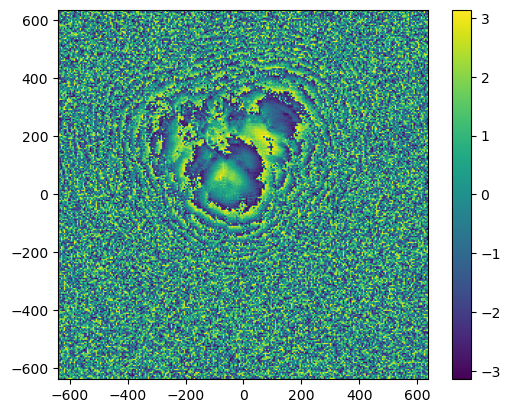

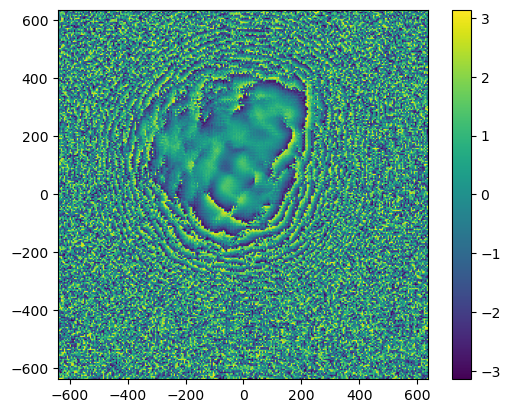

PyObject <matplotlib.colorbar.Colorbar object at 0x000000005C5557F0>

In [10]:
fig, ax = plt.subplots()
img=ax.imshow(theta[1,:,:],extent=(x[1],x[end],y[1],y[end]))
cbar=plt.colorbar(img)

fig, ax = plt.subplots()
img=ax.imshow(theta[2,:,:],extent=(x[1],x[end],y[1],y[end]))
cbar=plt.colorbar(img)



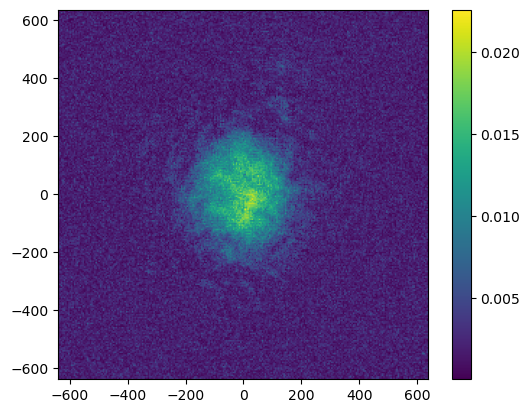

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000002660760>

In [11]:
fig, ax = plt.subplots()
img = ax.imshow(np.abs(e_o[1,:,:]),extent=(x[1],x[end],y[1],y[end]))
cbar = plt.colorbar(img)

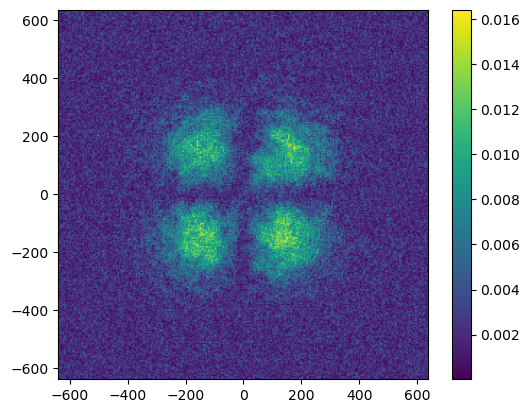

PyObject <matplotlib.colorbar.Colorbar object at 0x00000000550FD4C0>

In [12]:
fig, ax = plt.subplots()
img = ax.imshow(np.abs(e_o[5,:,:]),extent=(x[1],x[end],y[1],y[end]))
cbar = plt.colorbar(img)